# Gesture Recognition
This project is about using the RNN and Conv3D to recognize the gestures.


In [ ]:
import numpy as np
import os
import imageio
from skimage.transform import resize, rescale
import datetime
import os

import matplotlib.pyplot as plt

In [ ]:
import tensorflow as tf
print(tf.__version__)
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
tf.random.set_seed(30)

In [4]:
train_doc = np.random.permutation(open('/datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/datasets/Project_data/val.csv').readlines())
num_classes = 5  #number of softmax classes

In [5]:
curr_time = datetime.datetime.now()
train_path = '/datasets/Project_data/train'
val_path = '/datasets/Project_data/val'
num_train_sqns = len(train_doc)
print('# sequences for training =', num_train_sqns)
num_val_sqns = len(val_doc)
print('# seqences for validation =', num_val_sqns)

# sequences for training = 663
# seqences for validation = 100


/usr/local/lib/python3.8/dist-packages/keras_preprocessing/image/image_data_generator.py:337: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


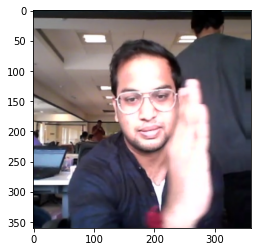

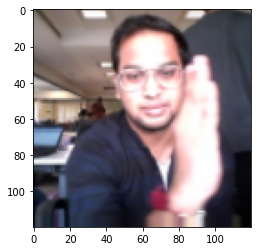

In [6]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    zoom_range=0.1,
    zca_whitening=True,
    width_shift_range=0.1,
    height_shift_range=0.1)


#viewing 360 by 360 image
image1 = imageio.imread("/datasets/Project_data/val/WIN_20180907_16_02_38_Pro_Right Swipe_new/WIN_20180907_16_02_38_Pro_00012.png")
#resize it. 
#print(image1.shape, image2.shape)
image2 = resize(image1, (120, 120), anti_aliasing=True)
image1 = datagen.random_transform(image1)                   
plt.imshow(image1)
plt.show()
image2 = resize(image2, (120, 120), anti_aliasing=True)
image2 = datagen.random_transform(image2)
#Viewing image after resizing
plt.imshow(image2)
plt.show()




# Generator
A generator is used to slice and provide the data ondeman for model learning, so that model gets trained optimumly, considering the machine and its configuration to handle the
huge data effectively.

In [7]:
def generate(source_path, folders, batch_size, num_imgs=20, height=120, width=120, augment=False):
    #print soruce path and batch size everytime new batch is asked from generator ( 'Source path = ', source_path, '; batch size =', batch_size)
    total_frames = 30

    while True:
        rndmSqns = np.random.permutation(folders)
        num_batches = len(rndmSqns)//batch_size # calculate the number of batches
        
        img_idx = np.round(np.linspace(0,total_frames-1,num_imgs)).astype(int) #create a list of image numbers 

        for batch in range(num_batches): 
            batch_data   = np.zeros((batch_size, num_imgs, height, width, 3)) # 3 is denoting RGB channles
            batch_lbls = np.zeros((batch_size, 5)) # one hot representation for batch lables in the output           

            for folder in range(batch_size): 
                imgs = os.listdir(source_path+'/'+ rndmSqns[folder + (batch*batch_size)].split(';')[0]) # read all the images from folder
                for idx,item in enumerate(img_idx): #  Iterate over the frames/images of a folder to read them in
                    image = imageio.imread(source_path+'/'+ rndmSqns[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                    #Crop and Resize the images. becasue images have 2 different sizes, conv3D will give error if the inputs images of diffn sizes                    
                    ht, wt, chl = image.shape
                    image = resize(image, (height, width), anti_aliasing=True)

                    if augment:
                        if np.random.randn() > 0:
                            image = datagen.random_transform(image)                   

                    batch_data[folder,idx,:,:,0] = (image[...,0])/255 #image normalization
                    batch_data[folder,idx,:,:,1] = (image[...,1])/255 #image normalization
                    batch_data[folder,idx,:,:,2] = (image[...,2])/255 #image normalization
                    
                batch_lbls[folder, int(rndmSqns[folder + (batch*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_lbls
        
        # write the code for the remaining data points which are left after full batches
        if (len(rndmSqns)%batch_size):
            remaining_batch_size = len(rndmSqns)%batch_size
            batch_data   = np.zeros((remaining_batch_size, num_imgs, height, width,3)) # 3 for RGB channles
            batch_lbls = np.zeros((remaining_batch_size,5))

            for folder in range(remaining_batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ rndmSqns[folder + (num_batches*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imageio.imread(source_path+'/'+ rndmSqns[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                
                    #Crop and Resize the images. becasue images have 2 different sizes, conv3D will give error if the inputs images of diffn sizes                    
                    ht, wt, chl = image.shape
                    image = resize(image, (height, width), anti_aliasing=True)                          
                    
                    if augment:
                        if np.random.randn() > 0:
                            image = datagen.random_transform(image)                   

                    batch_data[folder,idx,:,:,0] = (image[...,0])/255 
                    batch_data[folder,idx,:,:,1] = (image[...,1])/255 
                    batch_data[folder,idx,:,:,2] = (image[...,2])/255 
                    
                batch_lbls[folder, int(rndmSqns[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_lbls 

In [16]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, GRU, LSTM, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.regularizers import l2
from tensorflow import keras
from keras import optimizers


# Model
Creating model using convolutional layers and with 'relu' in hidden layers and output layer has the 'Softmax' as activation funciton.

In [123]:
# Common function for creating conv 3D model by simple method call
def conv3D(conv_filters=(16, 32, 64, 128), dense_nodes=(256,128), dropout=0.25, num_images=20, height=120, width=120):

    model = Sequential()

    model.add(Conv3D(conv_filters[0], (3, 3, 3), padding='same', input_shape=(num_images, height, width, 3)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(conv_filters[1], (3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    #model.add(Conv3D(conv_filters[2], (3, 3, 3), padding='same'))
    #model.add(Activation('relu'))
    #model.add(BatchNormalization())
    #model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    #model.add(Conv3D(conv_filters[3], (3, 3, 3), padding='same'))    
    #model.add(Activation('relu'))
    #model.add(BatchNormalization())
    #model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    model.add(Flatten())
    model.add(Dense(dense_nodes[0]))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(dense_nodes[1]))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    optimiser = tf.keras.optimizers.Adam(0.01)
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

    return model

# Model 1

In [124]:
num_epochs = 10 # experiment with epochs
print ('no of epochs =', num_epochs)
batch_size = 5  #experiment with batch size
print ('batch size =', batch_size)
num_frames = 15
print ('num_frames per video =', num_frames)
height = 120
width = 120

model = conv3D(num_images=num_frames)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])



print (model.summary())


no of epochs = 10
batch size = 5
num_frames per video = 15
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_64 (Conv3D)          (None, 15, 120, 120, 16)  1312      
                                                                 
 activation_112 (Activation)  (None, 15, 120, 120, 16)  0        
                                                                 
 batch_normalization_96 (Bat  (None, 15, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_64 (MaxPoolin  (None, 7, 60, 60, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_65 (Conv3D)          (None, 7, 60, 60, 32)     13856     
                                                            

# Common function for callbacks to be called for each model train run

In [10]:
def model_callbacks(folder):
    model_name = str(folder) + '_' + str(curr_time).replace(' ','').replace(':','_') + '/'
   
    if not os.path.exists(model_name):
        os.mkdir(model_name)

    filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')

    LR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.0001, cooldown=1, verbose=1) 

    return [checkpoint, LR]    

In [127]:
#common funciton to determine the steps per epoch

In [11]:
def calculate_steps(num_train_sqns, num_val_sqns, batch_size):
    if (num_train_sqns%batch_size) == 0:
        steps_per_epoch = int(num_train_sqns/batch_size)
    else:
        steps_per_epoch = (num_train_sqns//batch_size) + 1

    if (num_val_sqns%batch_size) == 0:
        validation_steps = int(num_val_sqns/batch_size)
    else:
        validation_steps = (num_val_sqns//batch_size) + 1

    return steps_per_epoch,validation_steps

In [151]:
callbacks_list = model_callbacks("model_conv3D_1")

steps_per_epoch, validation_steps = calculate_steps(num_train_sqns, num_val_sqns, batch_size)

train_generator = generate(train_path, train_doc, batch_size, num_imgs=num_frames)

val_generator   = generate(val_path, val_doc, batch_size, num_imgs=num_frames)

In [130]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                             callbacks=callbacks_list, validation_data=val_generator, 
                             validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/10
133/133 [==============================] - ETA: 0s - loss: 1.8670 - categorical_accuracy: 0.3499
Epoch 00001: val_loss improved from inf to 12.39315, saving model to model_conv3D_1_2023-08-1609_30_58.316635/model-00001-1.86703-0.34992-12.39315-0.23000.h5
133/133 [==============================] - 322s 2s/step - loss: 1.8670 - categorical_accuracy: 0.3499 - val_loss: 12.3931 - val_categorical_accuracy: 0.2300 - lr: 0.0100
Epoch 2/10
133/133 [==============================] - ETA: 0s - loss: 1.5126 - categorical_accuracy: 0.3831
Epoch 00002: val_loss improved from 12.39315 to 1.63197, saving model to model_conv3D_1_2023-08-1609_30_58.316635/model-00002-1.51258-0.38311-1.63197-0.36000.h5
133/133 [==============================] - 136s 1s/step - loss: 1.5126 - categorical_accuracy: 0.3831 - val_loss: 1.6320 - val_categorical_accuracy: 0.3600 - lr: 0.0100
Epoch 3/10
133/133 [==============================] - ETA: 0s - loss: 1.2029 - categorical_accuracy: 0.4992
Epoch 00003: val_l

# Model with 1 hiddne Conv3d layer did not give good stability so lets have another model with conv3d layer to see how it helps

In [24]:
# Common function for creating conv 3D model by simple method call
def conv3D(conv_filters=(16, 32, 64, 128), dense_nodes=(256,128), dropout=0.25, num_images=20, height=120, width=120):

    model = Sequential()

    model.add(Conv3D(conv_filters[0], (3, 3, 3), padding='same', input_shape=(num_images, height, width, 3)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(conv_filters[1], (3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    model.add(Conv3D(conv_filters[2], (3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    model.add(Conv3D(conv_filters[3], (3, 3, 3), padding='same'))    
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    model.add(Flatten())
    model.add(Dense(dense_nodes[0]))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(dense_nodes[1]))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    optimiser = tf.keras.optimizers.Adam(0.01)
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

    return model

# Model 2

In [153]:
num_epochs = 10 # experiment with epochs
print ('no of epochs =', num_epochs)
batch_size = 10  #experiment with batch size
print ('batch size =', batch_size)
num_frames = 18
print ('num_frames per video =', num_frames)
height = 120
width = 120

model2 = conv3D(num_images=num_frames)
model2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])



print (model2.summary())

no of epochs = 10
batch size = 10
num_frames per video = 18
Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_86 (Conv3D)          (None, 18, 120, 120, 16)  1312      
                                                                 
 activation_152 (Activation)  (None, 18, 120, 120, 16)  0        
                                                                 
 batch_normalization_130 (Ba  (None, 18, 120, 120, 16)  64       
 tchNormalization)                                               
                                                                 
 max_pooling3d_86 (MaxPoolin  (None, 9, 60, 60, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_87 (Conv3D)          (None, 9, 60, 60, 32)     13856     
                                                           

In [154]:
history = model2.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                             callbacks=callbacks_list, validation_data=val_generator, 
                             validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/10
67/67 [==============================] - ETA: 0s - loss: 1.4603 - categorical_accuracy: 0.4389
Epoch 00001: val_loss improved from inf to 4.64008, saving model to model_conv3D_1_2023-08-1610_05_02.948615/model-00001-1.46029-0.43891-4.64008-0.21000.h5
67/67 [==============================] - 169s 3s/step - loss: 1.4603 - categorical_accuracy: 0.4389 - val_loss: 4.6401 - val_categorical_accuracy: 0.2100 - lr: 1.0000e-04
Epoch 2/10
67/67 [==============================] - ETA: 0s - loss: 0.9776 - categorical_accuracy: 0.6350
Epoch 00002: val_loss did not improve from 4.64008
67/67 [==============================] - 153s 2s/step - loss: 0.9776 - categorical_accuracy: 0.6350 - val_loss: 7.7371 - val_categorical_accuracy: 0.2200 - lr: 1.0000e-04
Epoch 3/10
67/67 [==============================] - ETA: 0s - loss: 0.7405 - categorical_accuracy: 0.7044
Epoch 00003: val_loss did not improve from 4.64008
67/67 [==============================] - 140s 2s/step - loss: 0.7405 - categorical

# common graph plotting function

In [30]:
#common plotting function needed 
def view_loss_accuracy(history):
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


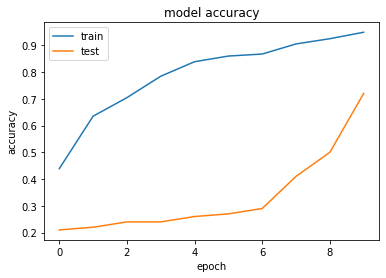

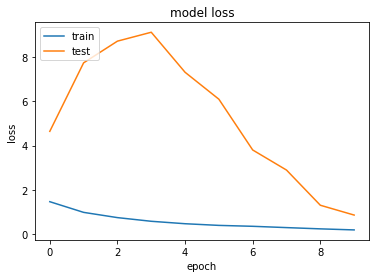

In [156]:
view_loss_accuracy(history)

In [157]:
# model having 3 hidden conv3d layers is performing stable is good, the accuracy is increasing by each epoch and also the validation loss is decreasing.
#seems like it is a good model to work with, lets increase the epochs and frame also t0 23 and see how it helps.

# Model 3

In [158]:
num_epochs = 15 # experiment with epochs
print ('no of epochs =', num_epochs)
batch_size = 10  #experiment with batch size
print ('batch size =', batch_size)
num_frames = 23
print ('num_frames per video =', num_frames)
height = 120
width = 120

model3 = conv3D(num_images=num_frames)
model3.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])


print (model3.summary())

no of epochs = 15
batch size = 10
num_frames per video = 23
Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_90 (Conv3D)          (None, 23, 120, 120, 16)  1312      
                                                                 
 activation_159 (Activation)  (None, 23, 120, 120, 16)  0        
                                                                 
 batch_normalization_136 (Ba  (None, 23, 120, 120, 16)  64       
 tchNormalization)                                               
                                                                 
 max_pooling3d_90 (MaxPoolin  (None, 11, 60, 60, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_91 (Conv3D)          (None, 11, 60, 60, 32)    13856     
                                                           

In [159]:
callbacks_list = model_callbacks("model_conv3D_3")

steps_per_epoch, validation_steps = calculate_steps(num_train_sqns, num_val_sqns, batch_size)

train_generator = generate(train_path, train_doc, batch_size, num_imgs=num_frames)

val_generator   = generate(val_path, val_doc, batch_size, num_imgs=num_frames)

In [160]:
history = model3.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                             callbacks=callbacks_list, validation_data=val_generator, 
                             validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/15
67/67 [==============================] - ETA: 0s - loss: 1.5167 - categorical_accuracy: 0.4646
Epoch 00001: val_loss improved from inf to 5.08987, saving model to model_conv3D_3_2023-08-1610_05_02.948615/model-00001-1.51670-0.46456-5.08987-0.16000.h5
67/67 [==============================] - 385s 6s/step - loss: 1.5167 - categorical_accuracy: 0.4646 - val_loss: 5.0899 - val_categorical_accuracy: 0.1600 - lr: 1.0000e-04
Epoch 2/15
67/67 [==============================] - ETA: 0s - loss: 1.0089 - categorical_accuracy: 0.6078
Epoch 00002: val_loss did not improve from 5.08987
67/67 [==============================] - 290s 4s/step - loss: 1.0089 - categorical_accuracy: 0.6078 - val_loss: 6.8414 - val_categorical_accuracy: 0.1600 - lr: 1.0000e-04
Epoch 3/15
67/67 [==============================] - ETA: 0s - loss: 0.5757 - categorical_accuracy: 0.7798
Epoch 00003: val_loss did not improve from 5.08987
67/67 [==============================] - 238s 4s/step - loss: 0.5757 - categorical

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


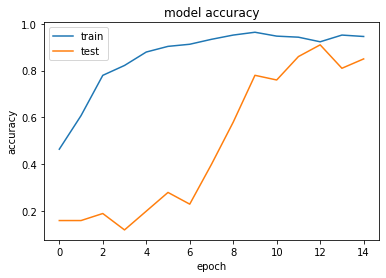

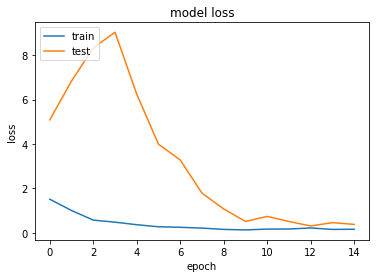

In [161]:
view_loss_accuracy(history)

# Model 4
previous model having 3 hidden conv3d layers is performing stable is good, after increasing and no of frames to 23 the model accuracy is improved to very good number.
also continuously improving with each epoch.

seems like model is good, and combination of epaches and frames have given a good accuracy and low loss. We can further see by increasing the epochs to 20. Because batch
size 10 seems to be a good value.

In [163]:
num_epochs = 20 # experiment with epochs
print ('no of epochs =', num_epochs)
batch_size = 10  #experiment with batch size
print ('batch size =', batch_size)
num_frames = 23
print ('num_frames per video =', num_frames)
height = 120
width = 120

model4 = conv3D(num_images=num_frames)
model4.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])


print (model4.summary())

no of epochs = 20
batch size = 10
num_frames per video = 23
Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_94 (Conv3D)          (None, 23, 120, 120, 16)  1312      
                                                                 
 activation_166 (Activation)  (None, 23, 120, 120, 16)  0        
                                                                 
 batch_normalization_142 (Ba  (None, 23, 120, 120, 16)  64       
 tchNormalization)                                               
                                                                 
 max_pooling3d_94 (MaxPoolin  (None, 11, 60, 60, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_95 (Conv3D)          (None, 11, 60, 60, 32)    13856     
                                                           

In [164]:
callbacks_list = model_callbacks("model_conv3D_4")

steps_per_epoch, validation_steps = calculate_steps(num_train_sqns, num_val_sqns, batch_size)

train_generator = generate(train_path, train_doc, batch_size, num_imgs=num_frames)

val_generator   = generate(val_path, val_doc, batch_size, num_imgs=num_frames)

In [165]:
history = model4.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                             callbacks=callbacks_list, validation_data=val_generator, 
                             validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20
67/67 [==============================] - ETA: 0s - loss: 1.4679 - categorical_accuracy: 0.4721
Epoch 00001: val_loss improved from inf to 4.19513, saving model to model_conv3D_4_2023-08-1610_05_02.948615/model-00001-1.46792-0.47210-4.19513-0.21000.h5
67/67 [==============================] - 123s 2s/step - loss: 1.4679 - categorical_accuracy: 0.4721 - val_loss: 4.1951 - val_categorical_accuracy: 0.2100 - lr: 1.0000e-04
Epoch 2/20
67/67 [==============================] - ETA: 0s - loss: 0.9575 - categorical_accuracy: 0.6335
Epoch 00002: val_loss did not improve from 4.19513
67/67 [==============================] - 122s 2s/step - loss: 0.9575 - categorical_accuracy: 0.6335 - val_loss: 7.2932 - val_categorical_accuracy: 0.2000 - lr: 1.0000e-04
Epoch 3/20
67/67 [==============================] - ETA: 0s - loss: 0.6987 - categorical_accuracy: 0.7466
Epoch 00003: val_loss did not improve from 4.19513
67/67 [==============================] - 122s 2s/step - loss: 0.6987 - categorical

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


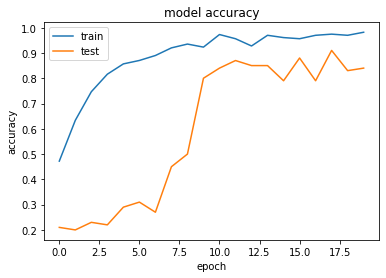

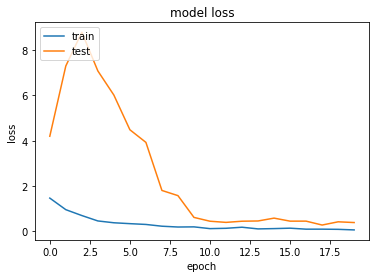

In [166]:
view_loss_accuracy(history)

# Model 5

In [25]:
num_epochs = 20 # experiment with epochs
print ('no of epochs =', num_epochs)
batch_size = 10  #experiment with batch size
print ('batch size =', batch_size)
num_frames = 28
print ('num_frames per video =', num_frames)
height = 120
width = 120

model5 = conv3D(num_images=num_frames)



print (model5.summary())

no of epochs = 20
batch size = 10
num_frames per video = 28
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_24 (Conv3D)          (None, 28, 120, 120, 16)  1312      
                                                                 
 activation_42 (Activation)  (None, 28, 120, 120, 16)  0         
                                                                 
 batch_normalization_36 (Bat  (None, 28, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_24 (MaxPoolin  (None, 14, 60, 60, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_25 (Conv3D)          (None, 14, 60, 60, 32)    13856     
                                                            

In [26]:
callbacks_list = model_callbacks("model_conv3D_5")

steps_per_epoch, validation_steps = calculate_steps(num_train_sqns, num_val_sqns, batch_size)

train_generator = generate(train_path, train_doc, batch_size, num_imgs=num_frames)

val_generator   = generate(val_path, val_doc, batch_size, num_imgs=num_frames)

In [28]:
history = model5.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                             callbacks=callbacks_list, validation_data=val_generator, 
                             validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20


2023-08-16 12:56:59.680629: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


67/67 [==============================] - ETA: 0s - loss: 1.7854 - categorical_accuracy: 0.3590
Epoch 00001: val_loss improved from inf to 66.28517, saving model to model_conv3D_5_2023-08-1612_45_37.899832/model-00001-1.78541-0.35897-66.28517-0.21000.h5
67/67 [==============================] - 157s 2s/step - loss: 1.7854 - categorical_accuracy: 0.3590 - val_loss: 66.2852 - val_categorical_accuracy: 0.2100 - lr: 0.0100
Epoch 2/20
67/67 [==============================] - ETA: 0s - loss: 1.2198 - categorical_accuracy: 0.5309
Epoch 00002: val_loss improved from 66.28517 to 10.01465, saving model to model_conv3D_5_2023-08-1612_45_37.899832/model-00002-1.21981-0.53092-10.01465-0.24000.h5
67/67 [==============================] - 149s 2s/step - loss: 1.2198 - categorical_accuracy: 0.5309 - val_loss: 10.0147 - val_categorical_accuracy: 0.2400 - lr: 0.0100
Epoch 3/20
67/67 [==============================] - ETA: 0s - loss: 1.0728 - categorical_accuracy: 0.5837
Epoch 00003: val_loss improved from 

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


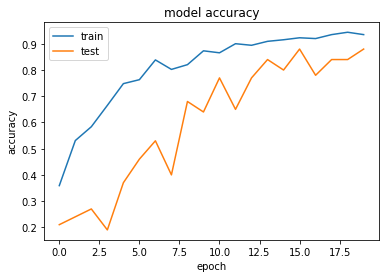

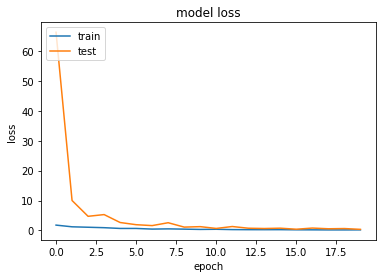

In [31]:
view_loss_accuracy(history)

To have more accurate model, as this is sequenced based learning, we are creating RNN model as below

In [47]:
from keras.applications import mobilenet

def RNN_Model(fine_tune=False, gru=False, lstm_gru_cells=128, dense_nodes=128, dropout=0.25, num_images=20, height=120, width=120):

    mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)
    print("Total Layers in RNN model: ", len(mobilenet_transfer.layers))

    if (fine_tune):
        # Fine-tune from this layer onwards
        fine_tune_at = 50
        # Freeze all the layers before the `fine_tune_at` layer
        for layer in mobilenet_transfer.layers[:fine_tune_at]:
            layer.trainable = False

    model = Sequential()
    model.add(TimeDistributed(mobilenet_transfer,input_shape=(num_images, height, width, 3)))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Flatten()))
    if (gru):
        model.add(GRU(lstm_gru_cells))
    else:
        model.add(LSTM(lstm_gru_cells))
    model.add(Dropout(dropout))
    model.add(Dense(dense_nodes, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(num_classes, activation='softmax'))
  
    optimiser = tf.keras.optimizers.Adam()
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    return model

# RNN GRU model1 using MobileNetwork

# RNN GRU Model 1

In [53]:
num_epochs = 10 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 5  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 20
print ('# num frames per video =', num_frames)
height = 120
width = 120

modelrnn1 = RNN_Model(num_images=num_frames, gru=True)
print (modelrnn1.summary())

# epochs = 10
# batch size = 5
# num frames per video = 20
Total Layers in RNN model:  86
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_20 (TimeDi  (None, 20, 3, 3, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_21 (TimeDi  (None, 20, 3, 3, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_22 (TimeDi  (None, 20, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_23 (TimeDi  (None, 20, 1024)         0         
 stributed)                                                      
                             

In [54]:
callbacks_list = model_callbacks("RNN_Model_1")

steps_per_epoch, validation_steps = calculate_steps(num_train_sqns, num_val_sqns, batch_size)

train_generator = generate(train_path, train_doc, batch_size, num_imgs=num_frames)

val_generator   = generate(val_path, val_doc, batch_size, num_imgs=num_frames)

In [55]:
history = modelrnn1.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                             callbacks=callbacks_list, validation_data=val_generator, 
                             validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/10
133/133 [==============================] - ETA: 0s - loss: 1.0826 - categorical_accuracy: 0.5732
Epoch 00001: val_loss improved from inf to 0.61938, saving model to RNN_Model_1_2023-08-1612_45_37.899832/model-00001-1.08261-0.57315-0.61938-0.74000.h5
133/133 [==============================] - 108s 793ms/step - loss: 1.0826 - categorical_accuracy: 0.5732 - val_loss: 0.6194 - val_categorical_accuracy: 0.7400 - lr: 0.0010
Epoch 2/10
133/133 [==============================] - ETA: 0s - loss: 0.5541 - categorical_accuracy: 0.8115
Epoch 00002: val_loss improved from 0.61938 to 0.47764, saving model to RNN_Model_1_2023-08-1612_45_37.899832/model-00002-0.55409-0.81146-0.47764-0.83000.h5
133/133 [==============================] - 105s 796ms/step - loss: 0.5541 - categorical_accuracy: 0.8115 - val_loss: 0.4776 - val_categorical_accuracy: 0.8300 - lr: 0.0010
Epoch 3/10
133/133 [==============================] - ETA: 0s - loss: 0.4099 - categorical_accuracy: 0.8643
Epoch 00003: val_loss 

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


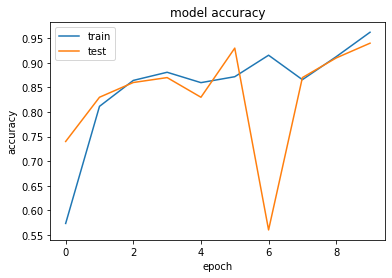

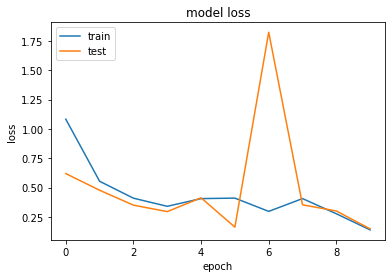

In [56]:
view_loss_accuracy(history)

# RNN GRU model2 using MobileNetwork

In [57]:
num_epochs = 10 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 30
print ('# num frames per video =', num_frames)
height = 120
width = 120

modelrnn2 = RNN_Model(num_images=num_frames, gru=True)
print (modelrnn2.summary())

# epochs = 10
# batch size = 10
# num frames per video = 30
Total Layers in RNN model:  86
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_24 (TimeDi  (None, 30, 3, 3, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_25 (TimeDi  (None, 30, 3, 3, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_26 (TimeDi  (None, 30, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_27 (TimeDi  (None, 30, 1024)         0         
 stributed)                                                      
                            

In [58]:
callbacks_list = model_callbacks("RNN_Model_2")

steps_per_epoch, validation_steps = calculate_steps(num_train_sqns, num_val_sqns, batch_size)

train_generator = generate(train_path, train_doc, batch_size, num_imgs=num_frames)

val_generator   = generate(val_path, val_doc, batch_size, num_imgs=num_frames)

In [59]:
history = modelrnn2.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                             callbacks=callbacks_list, validation_data=val_generator, 
                             validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/10
67/67 [==============================] - ETA: 0s - loss: 1.1446 - categorical_accuracy: 0.5385
Epoch 00001: val_loss improved from inf to 0.86265, saving model to RNN_Model_2_2023-08-1612_45_37.899832/model-00001-1.14462-0.53846-0.86265-0.66000.h5
67/67 [==============================] - 163s 2s/step - loss: 1.1446 - categorical_accuracy: 0.5385 - val_loss: 0.8626 - val_categorical_accuracy: 0.6600 - lr: 0.0010
Epoch 2/10
67/67 [==============================] - ETA: 0s - loss: 0.4439 - categorical_accuracy: 0.8446
Epoch 00002: val_loss improved from 0.86265 to 0.57169, saving model to RNN_Model_2_2023-08-1612_45_37.899832/model-00002-0.44389-0.84465-0.57169-0.76000.h5
67/67 [==============================] - 159s 2s/step - loss: 0.4439 - categorical_accuracy: 0.8446 - val_loss: 0.5717 - val_categorical_accuracy: 0.7600 - lr: 0.0010
Epoch 3/10
67/67 [==============================] - ETA: 0s - loss: 0.3459 - categorical_accuracy: 0.8974
Epoch 00003: val_loss improved from 0.

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


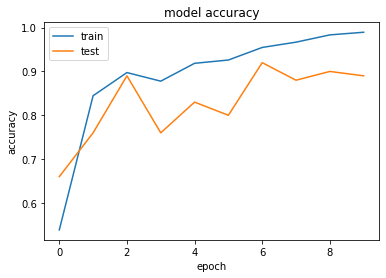

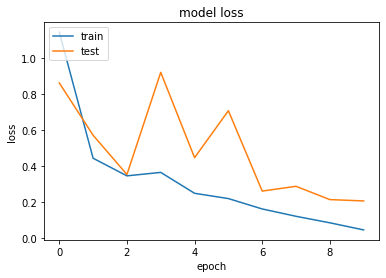

In [60]:
view_loss_accuracy(history)

# RNN LSTM model using MobileNetwork

In [61]:
num_epochs = 10 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 30
print ('# num frames per video =', num_frames)
height = 120
width = 120

modelrnnLstm1 = RNN_Model(num_images=num_frames, fine_tune=False, gru=False)
print (modelrnnLstm1.summary())

# epochs = 10
# batch size = 10
# num frames per video = 30
Total Layers in RNN model:  86
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_28 (TimeDi  (None, 30, 3, 3, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_29 (TimeDi  (None, 30, 3, 3, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_30 (TimeDi  (None, 30, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_31 (TimeDi  (None, 30, 1024)         0         
 stributed)                                                      
                            

In [62]:
callbacks_list = model_callbacks("RNN_Model_3_Lstm")

steps_per_epoch, validation_steps = calculate_steps(num_train_sqns, num_val_sqns, batch_size)

train_generator = generate(train_path, train_doc, batch_size, num_imgs=num_frames)

val_generator   = generate(val_path, val_doc, batch_size, num_imgs=num_frames)

In [64]:
history = modelrnnLstm1.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                             callbacks=callbacks_list, validation_data=val_generator, 
                             validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/10
67/67 [==============================] - ETA: 0s - loss: 0.0503 - categorical_accuracy: 0.9910
Epoch 00001: val_loss did not improve from 0.33946
67/67 [==============================] - 157s 2s/step - loss: 0.0503 - categorical_accuracy: 0.9910 - val_loss: 0.3546 - val_categorical_accuracy: 0.9000 - lr: 1.0000e-04
Epoch 2/10
67/67 [==============================] - ETA: 0s - loss: 0.0474 - categorical_accuracy: 0.9910
Epoch 00002: val_loss did not improve from 0.33946
67/67 [==============================] - 156s 2s/step - loss: 0.0474 - categorical_accuracy: 0.9910 - val_loss: 0.3975 - val_categorical_accuracy: 0.9000 - lr: 1.0000e-04
Epoch 3/10
67/67 [==============================] - ETA: 0s - loss: 0.0229 - categorical_accuracy: 0.9955
Epoch 00003: val_loss did not improve from 0.33946
67/67 [==============================] - 157s 2s/step - loss: 0.0229 - categorical_accuracy: 0.9955 - val_loss: 0.3890 - val_categorical_accuracy: 0.9000 - lr: 1.0000e-04
Epoch 4/10
67/67

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


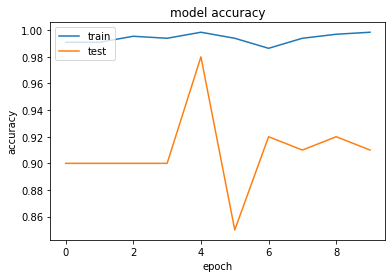

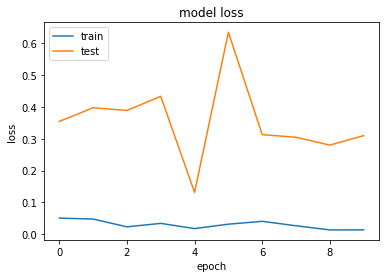

In [65]:
view_loss_accuracy(history)